$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Ridge Regression with K-Fold Cross-Validation on Yacht Hydrodynamics Dataset

## Overview

The objective of this project is to apply **Ridge Regression Model** to Yacht Hydrodynamics Dataset.

This data set consists of 7 attributes and 308 full-scale experiments, which were performed at the Delft Ship Hydromechanics Laboratory.

Multiple $\lambda$ values are taken and for each value of $\lambda$, the data is partitioned into multiple folds of which one fold is taken as test data, one fold as validation data and the remaining folds for training. Then the RMSE(Root Mean Square Error) is calculated and we verify which $\lambda$ value gives the best results.

## Method

Ridge regression generally yields better predictions than ordinary least squares solution, through a better compromise between bias and variance. It reduces the sum of squared errors.

If we add a term to our sum of squared error objective function that is the sum of all weight magnitudes except the bias weight.  Then, we not only minimize the sum of squared errors, we also minimize the sum of the weight magnitudes:

$$ \sum_{i=1}^N (\tv_i - \xv_i^T \wv)^2 + \lambda \sum_{i=2}^N w_i^2$$

With $\lambda=0$ we have our usual linear regression objective function. With $\lambda>0$, we are adding in a penalty for the weight magnitudes. So we get the equation for weight as

$$ \wv = (X^T X + \lambda I)^{-1} X^T T $$

If we find the best value of $\lambda$ by comparing error on the test data, it will give us an optimistic prediction of error on novel data, because the test data was used to pick the best $\lambda$.

Instead of comparing the error only on test data, we partition the data into multiple ($k$) subsets called "folds". We select one fold to be the test partition, another fold to be the validate partition, and collect the remaining folds to be the train partition.  We can do this in $k\,(k-1)$ ways. So, with $k=5$ we get 20 repetitions performed in a way that most distributes samples among the partitions. We use the **partitionKFolds** algorithm for this purpose.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
 def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=3):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold

Now for each value of $\lambda$ we do the following operations
  * Solve for $\wv$ using the training set
  * Use $\wv$ to predict the output for the validation set and calculate the squared error.
  * Use $\wv$ to predict the output for the testing set and calculate the squared error.
  * Pick value of $\lambda$ that produced the lowest validation set error, and report the testing set error obtained using that value of $\lambda$.

The **train** method returns a model which consists of a key with the weights, means and standard Deviations. This model is the used by the **use** method which gives the predicted model and then using the **rmse** method, we calculate the Root Mean Square Error.

In [3]:
def train(X,T,lamb):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( np.dot(Xs1.T,Xs1) + lambDiag, np.dot(Xs1.T,T))[0]
    return {'w': w, 'means':means, 'stds':stds}

def use(X,model):
    Xs1 = np.insert((X-model['means'])/model['stds'], 0, 1, axis=1)
    return np.dot(Xs1,model['w'])

def rmse(A,B):
    return np.sqrt(np.mean( (A-B)**2 ))

For different values of $\lambda$, we now partition the data into multiple folds and then find the best $\lambda$ value for each fold i.e., the lambda value which gives the least validation error.

In [4]:
def multipleLambdas(X, T, nFolds, lambdas):
    foldCount = 0
    results = []
    for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds,True):
        for lamb in lambdas:
            model = train(Xtrain,Ttrain,lamb)
            predict = use(Xval,model)
            results.append([foldCount,lamb,rmse(use(Xtrain,model),Ttrain),rmse(use(Xval,model),Tval),rmse(use(Xtest,model),Ttest)])
        foldCount +=1
    results = np.array(results)
    bestresults = []  
    for i in range(foldCount):
        FCRow = np.take(results,(np.where(results[:,0:1] == i))[0], axis =0)
        minRow = np.where(results[:,3:4] == (np.amin(FCRow[:,3:4],axis=0)))[0]
        bestresults.append(np.take(results,minRow,axis=0))
    bestresults = np.array(bestresults)
    bestresults = bestresults.reshape(bestresults.shape[0], bestresults.shape[2])
    return bestresults 

## Data

The data used is taken from UCI Machine Learning Repository. 
http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics

The creator of the data source is : Ship Hydromechanics Laboratory, Maritime and Transport Technology Department, Technical University of Delft and the Donor is Dr.Roberto Lopez.

The Delft data set comprises 7 attributes and 308 full-scale experiments, which were performed at the Delft Ship Hydromechanics Laboratory for that purpose. 

* Longitudinal position of the center of buoyancy. 
* Prismatic coefficient. 
* Length-displacement ratio. 
* Beam-draught ratio. 
* Length-beam ratio. 
* Froude number. 

The measured variable is the residuary resistance per unit weight of displacement: 

* Residuary resistance per unit weight of displacement. 

We can visualize this data by plotting each value on a seperate graph. Lets first make an array of column names to label the y-axis.

In [6]:
names =  ['vendor name','Model',' MYCT','MMIN',
           'MMAX','CACH','CHMIN','CHMAX','PRP']
names

['longitudinal Position',
 'Prismatic Coefficient',
 'Length-Displacement Ratio',
 'Beam-draught ratio',
 'length-beam ratio',
 'froude number']

We can plot all of them against the measuring value (quality) on graphs

In [7]:
X = data[:,0:9]
T = data[:,9:10]

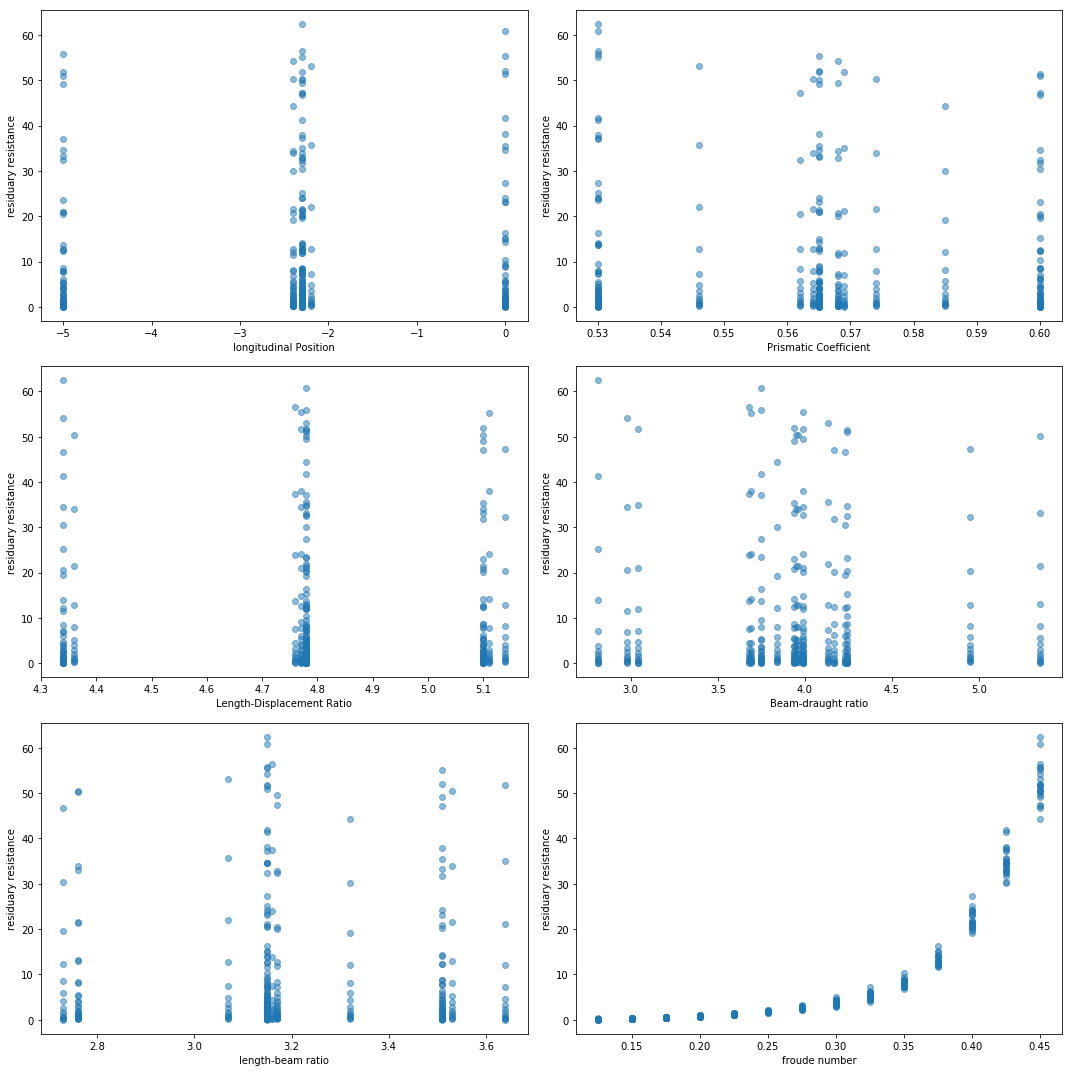

In [8]:
plt.figure(figsize=(15,15))
for c in range(X.shape[1]):
    plt.subplot(3,2, c+1)
    plt.plot(X[:,c], T, 'o', alpha=0.5)
    plt.ylabel('residuary resistance')
    plt.xlabel(names[c])
plt.tight_layout()

From the above plotted graphs, we can see that with the increase in the froude number, the residuary resistance also increases and the other attributes do not directly affect the residuary resistance but when combined with any other attribute, they may affect the resistance.

## Results

Now to determine the best results for the model, we use different values of lambda and apply the above **multipleLambdas** method.  

In [9]:
lambdas = [0,1,2,3,4,5]
bestresults = multipleLambdas(X,T,4,lambdas)
print bestresults

[[  0.           5.           8.81426164  10.03480993   8.07064809]
 [  1.           5.           9.74551084   7.96705615   8.24472816]
 [  2.           0.           8.60185258  10.33068072   8.10777218]
 [  3.           5.           8.81426164   8.07064809  10.03480993]
 [  4.           5.           8.91920108   7.76216789  10.08141138]
 [  5.           0.           7.42666368  10.74890819  10.30521868]
 [  6.           5.           9.74551084   8.24472816   7.96705615]
 [  7.           5.           8.91920108  10.08141138   7.76216789]
 [  8.           2.           8.65114338  10.48231849   7.89881182]
 [  9.           5.           8.61061748   8.07133713  10.40484967]
 [ 10.           0.           7.42666368  10.30521868  10.74890819]
 [ 11.           5.           8.66275635   7.87422176  10.5165854 ]]


Now if we plot the best rmse values against $\lambda$ we get the following graph 

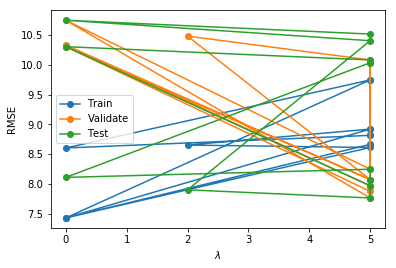

In [10]:
plt.plot(bestresults[:,1],bestresults[:,2:],'o-')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best');

Now if we plot the bestresults for each fold, we get the following graph

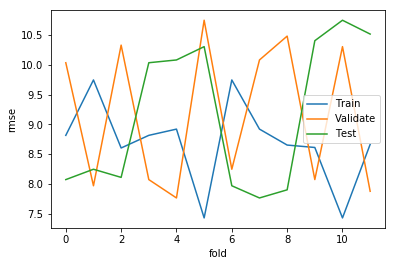

In [11]:
plt.plot(bestresults[:,0], bestresults[:,2:])
plt.legend(('Train','Validate','Test'),loc='best');
plt.xlabel('fold')
plt.ylabel('rmse')

(array([ 3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  8.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

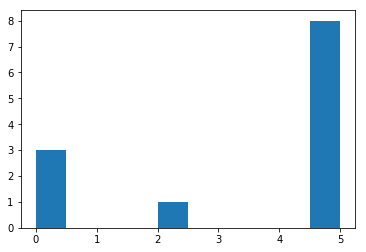

In [12]:
plt.hist(bestresults[:,1])

This shows that the rmse is least for $\lambda=5$ in most folds which means that this is same as the linear regression objective function.

Now let us try for a different set of $\lambda$ values and see how the model changes

In [13]:
lambdas = [5,10,100,1000]
bestresults = multipleLambdas(X,T,4,lambdas)
print bestresults

[[   0.           10.            8.71586882    7.7443807    10.29607493]
 [   1.            5.            7.8895193     9.48860747   10.57378518]
 [   2.            5.            8.2906773     8.88627673   10.73041578]
 [   3.            5.            8.69097174   10.23277486    7.86551942]
 [   4.           10.            9.06649018    9.50931324    8.1336331 ]
 [   5.            5.            9.55706868    8.45314097    7.98979739]
 [   6.            5.            7.8895193    10.57378518    9.48860747]
 [   7.          100.           10.43749588    7.88350099   10.34269986]
 [   8.            5.            8.9357571     8.43312821    9.29485305]
 [   9.            5.            8.2906773    10.73041578    8.88627673]
 [  10.           10.            9.58338214    7.87466603    8.45886354]
 [  11.            5.            8.9357571     9.29485305    8.43312821]]


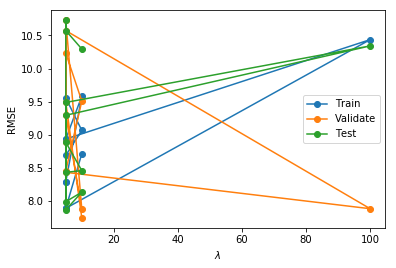

In [14]:
plt.plot(bestresults[:,1],bestresults[:,2:],'o-')
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')
plt.legend(('Train','Validate','Test'),loc='best');

(array([ 11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   5. ,   14.5,   24. ,   33.5,   43. ,   52.5,   62. ,   71.5,
          81. ,   90.5,  100. ]),
 <a list of 10 Patch objects>)

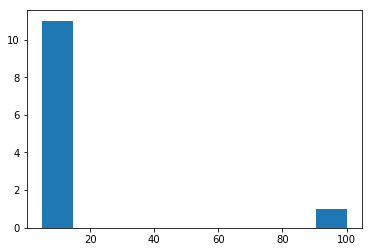

In [15]:
plt.hist(bestresults[:,1])

We still get the $\lambda$ value approximately 5 for most of the folds. Also the validation error is between 7 and 8 in most of the folds which is lesser than the error we get using the linear model(9.789).